In [12]:
import pandas as pd
import numpy as np
import optuna
import warnings
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
#importazione dei dataset
raw_data = fetch_california_housing()
data = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)
data['MedHouseVal'] = raw_data.target

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [14]:
#rimozione outlier
numeric_cols = data.select_dtypes(include=["float", "int"]).columns.tolist()

for col in numeric_cols:
    Q1 = data[col].quantile(0.3)
    Q3 = data[col].quantile(0.7)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    data[col] = np.where(data[col].between(lower, upper), data[col], np.nan)

data = data.dropna()

#features combinate
data['Ave_Room_Bed'] = data['AveRooms'] / data['AveBedrms']
data['HouseRooms'] = data['HouseAge'] / data['AveRooms']
data["BedroomsPerRoom"] = data["AveBedrms"] / data["AveRooms"]
data["Households"] = (data["Population"] / data["AveOccup"]).clip(lower=1)
data["RoomsPerHousehold"] = data["AveRooms"] / data["Households"]
data["PopulationPerHousehold"] = data["Population"] / data["Households"]
data["RoomsPerPerson"] = data["AveRooms"] / (data["Population"] + 1)


data["MedInc_log"] = np.log1p(data["MedInc"])
data["Population_log"] = np.log1p(data["Population"])
data["IncomePerOccupant"] = data["MedInc"] / (data["AveOccup"] + 1)
data["PopPerHousehold"] = data["Population"] / (data["Households"] + 1)



In [ ]:
from sklearn.model_selection import KFold

def objective(trial, X_train, y_train):
    # Assicurati che siano numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 1e-7, 1.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-9, 15.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-9, 15.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
    }

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, valid_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[valid_idx]
        y_tr, y_val = y_train[train_idx], y_train[valid_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dvalid = xgb.DMatrix(X_val, label=y_val)

        model = xgb.train(
            param,
            dtrain,
            num_boost_round=1000,
            evals=[(dvalid, "validation")],
            early_stopping_rounds=100,
            verbose_eval=False
        )

        preds = model.predict(dvalid)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)


In [ ]:
#X, y = data.data, data.target
X = data.drop(columns=["MedHouseVal"])
y= data["MedHouseVal"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

print(f"Dataset Shape: {X.shape}")
print(f"Target medio: {np.mean(y):.2f} (centinaia di k$)")

# ==========================================
# 2. Baseline (Senza Tuning)
# ==========================================
print("\n--- Training Modello Baseline (Default) ---")
dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_full)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Parametri standard di default
params_base = {
    'objective': 'reg:squarederror', # Regressione
    'tree_method': 'hist',
    'random_state': 42
}

model_base = xgb.train(params_base, dtrain_full, num_boost_round=100)
preds_base = model_base.predict(dtest)

# Calcolo RMSE Baseline
rmse_base = np.sqrt(mean_squared_error(y_test, preds_base))
print(f"Baseline RMSE: {rmse_base:.4f}")


# ==========================================
# 3. Ottimizzazione con Optuna
# ==========================================
print("\n--- Inizio Tuning con Optuna ---")

# Creazione Studio (Minimizzare RMSE)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train_scaled, y_train_full), n_trials=200)


print(f"\nMiglior RMSE trovato da Optuna (Validation): {study.best_value:.4f}")
print("Migliori parametri:", study.best_params)


# ==========================================
# 4. Training Modello Finale (Best Params + Shrinkage)
# ==========================================
print("\n--- Training Modello Finale Ottimizzato ---")

best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'rmse'
best_params['tree_method'] = 'hist'

# STRATEGIA "SHRINKAGE" (Raffiniamo la discesa del gradiente)
# Abbassiamo il learning rate trovato per maggiore precisione finale
best_params['learning_rate'] = best_params['learning_rate'] * 0.5 
# Aumentiamo gli alberi di conseguenza (safety buffer alto, early stopping gestirà il resto)
num_round_final = 5000 

model_opt = xgb.train(
    best_params, 
    dtrain_full, 
    num_boost_round=num_round_final,
    evals=[(dtest, "test")], # Test set usato SOLO per fermare il training al punto giusto
    early_stopping_rounds=100,
    verbose_eval=False
)

# ==========================================
# 5. Analisi Risultati
# ==========================================
print("\n--- CONFRONTO FINALE ---")

preds_opt = model_opt.predict(dtest)
rmse_opt = np.sqrt(mean_squared_error(y_test, preds_opt))

# R2 Score (coefficiente di determinazione)
r2_base = r2_score(y_test, preds_base)
r2_opt = r2_score(y_test, preds_opt)

print(f"RMSE Baseline:    {rmse_base:.4f}")
print(f"RMSE Ottimizzato: {rmse_opt:.4f}")
print(f"--> Miglioramento Errore: {rmse_base - rmse_opt:.4f} (Minore è meglio)")
print("-" * 30)
print(f"R2 Score Baseline:    {r2_base:.4f}")
print(f"R2 Score Ottimizzato: {r2_opt:.4f}")
print(f"--> Varianza Spiegata Extra: +{(r2_opt - r2_base)*100:.2f}%")

Dataset Shape: (13561, 19)
Target medio: 1.85 (centinaia di k$)

--- Training Modello Baseline (Default) ---


[I 2025-12-09 16:39:08,756] A new study created in memory with name: no-name-85a3085d-4bbf-4668-a875-d7c8af34ab89
[W 2025-12-09 16:39:08,760] Trial 0 failed with parameters: {'max_depth': 14, 'min_child_weight': 6, 'gamma': 3.889957491057088e-07, 'subsample': 0.7764747179895973, 'colsample_bytree': 0.720417593528051, 'lambda': 0.7172102105574525, 'alpha': 3.508000887910829e-06, 'learning_rate': 0.14064371552595248} because of the following error: ValueError('k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.').
Traceback (most recent call last):
  File "D:\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\sorre\AppData\Local\Temp\ipykernel_5376\2162396.py", line 43, in <lambda>
    study.optimize(lambda trial: objective(trial, X_train_scaled, y_train_full), n_trials=50, n_jobs=4)
                                 ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Baseline RMSE: 0.3545

--- Inizio Tuning con Optuna ---


[W 2025-12-09 16:39:08,787] Trial 3 failed with value None.


ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

**RISULTATO**

RMSE Baseline:    0.4718
RMSE Ottimizzato: 0.4300

param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse', # Metrica per early stopping e pruning
        'tree_method': 'hist',
        
        # --- Struttura ---
        # California ha interazioni complesse, permettiamo alberi più profondi
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        # Importante per evitare overfitting su outlier di prezzo
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        
        # --- Randomness ---
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        
        # --- Regolarizzazione ---
        # Fondamentale nella regressione per non inseguire i prezzi estremi
        'lambda': trial.suggest_float('lambda', 1e-9, 25.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-9, 25.0, log=True),
        
        # --- Learning ---
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
    }

study.optimize(objective, n_trials=70, timeout=600)

=============================================================================== <br>
RMSE Baseline:    0.4718
RMSE Ottimizzato: 0.4310

con scaler

param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse', # Metrica per early stopping e pruning
        'tree_method': 'hist',
        
        # --- Struttura ---
        # California ha interazioni complesse, permettiamo alberi più profondi
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        # Importante per evitare overfitting su outlier di prezzo
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 25),
        'gamma': trial.suggest_float('gamma', 1e-9, 1.5, log=True),
        
        # --- Randomness ---
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        
        # --- Regolarizzazione ---
        # Fondamentale nella regressione per non inseguire i prezzi estremi
        'lambda': trial.suggest_float('lambda', 1e-6, 20.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-6, 20.0, log=True),
        
        # --- Learning ---
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.8),
    }

study.optimize(objective, n_trials=200, timeout=600)

=============================================================================== <br>

RMSE Baseline:    0.3522
RMSE Ottimizzato: 0.3379

con scaler

study.optimize(objective, n_trials=200, timeout=600)

param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse', # Metrica per early stopping e pruning
        'tree_method': 'hist',
        
        # --- Struttura ---
        # California ha interazioni complesse, permettiamo alberi più profondi
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        # Importante per evitare overfitting su outlier di prezzo
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 25),
        'gamma': trial.suggest_float('gamma', 1e-7, 1.5, log=True),
        
        # --- Randomness ---
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        
        # --- Regolarizzazione ---
        # Fondamentale nella regressione per non inseguire i prezzi estremi
        'lambda': trial.suggest_float('lambda', 1e-9, 15.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-9, 15.0, log=True),
        
        # --- Learning ---
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.6),
    }

#rimozione outlier
numeric_cols = data.select_dtypes(include=["float", "int"]).columns.tolist()

for col in numeric_cols:
    Q1 = data[col].quantile(0.3)
    Q3 = data[col].quantile(0.7)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    data[col] = np.where(data[col].between(lower, upper), data[col], np.nan)

data = data.dropna()

#features combinate
data['Ave_Room_Bed'] = data['AveRooms'] / data['AveBedrms']
data['HouseRooms'] = data['HouseAge'] / data['AveRooms']

Miglior RMSE trovato da Optuna (Validation): 0.3544
Migliori parametri: {'max_depth': 13, 'min_child_weight': 23, 'gamma': 3.8838420870962745e-06, 'subsample': 0.7570628531701007, 'colsample_bytree': 0.9109736816364161, 'lambda': 0.02307771384295654, 'alpha': 0.9454327224813569, 'learning_rate': 0.06885420667941514}

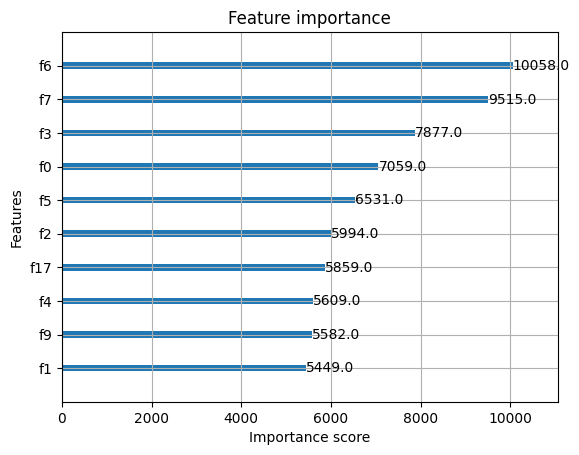

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_importance(model_opt, max_num_features=10)
plt.show()
